# Previsione a 14 giorni

Previsione a 14 giorni con modello SARIMA.

> Max Pierini

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

I nuovi casi giornalieri previsti a 14 giorni sono stimati utilizzando un modello di autoregressione $\mathrm{SARIMA}(p,d,q)\times(P,D,Q,s)$, i cui parametri ottimali sono stati determinati per [grid-search](https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b) sul prodotto cartesiano di range empirici, scegliendo la combinazione di parametri che [minimizzi](https://machinelearningmastery.com/probabilistic-model-selection-measures/) il Bayesian Information Criterion ([BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)).

In modello migliore è attualmente

$$
\mathrm{SARIMA}(0, 1, 6)\times(0, 1, 10, 7)
$$

con BIC = $5269.954$. I parametri potrebbero essere ulteriormente affinati con successive grid-search mirate.

I nuovi casi ad un giorno sono stimati anche con modello ad albero decisionale [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) (**GBS-SML**) in Supervised Machine Learning con `scikit-learn`, basato sull'osservazione della derivata prima dei nuovi positivi dei 28 giorni precedenti e i cui parametri ottimali sono stati determinati per cross-validation.

In [1]:
import numpy as np
import pandas as pd
import itertools
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)

In [3]:
df.index = df.index.normalize()

In [4]:
df['variazione_nuovi_positivi'] = df.nuovi_positivi.diff()

In [5]:
ts = df[['variazione_nuovi_positivi']].dropna()

In [6]:
features_n = 7 * 4
DF = pd.DataFrame(
    columns=[f'day_{i}' for i in range(features_n + 1)],
    index=ts.index[features_n:]
)
for i in range(features_n + 1):
    _df = ts.iloc[i:(ts.index.size - features_n + i)]
    #print(_df.size)
    DF.iloc[:,i] = _df.values

In [7]:
X_train = DF.iloc[:,:7*4]
Y_train = DF.iloc[:,-1].values

In [8]:
# Initialize the estimator
mdl = GradientBoostingRegressor(
    n_estimators=1000, criterion='mse',
    min_samples_split=5,
    random_state=1976
)
# Fit the data
mdl.fit(X_train, Y_train)
# Make predictions
Y_pred = mdl.predict(X_train)
score = mdl.score(X_train, Y_train)

In [9]:
Y_future = mdl.predict(pd.DataFrame(DF.iloc[-1,1:]).T)[0] + df.nuovi_positivi.values[-1]
X_future = df.index[-1] + pd.Timedelta(days=1)
Y_obs = df.nuovi_positivi[29:]
Y_pre = pd.DataFrame({
    'nuovi_positivi': Y_pred.cumsum()+df.nuovi_positivi[28]
}, index=Y_obs.index)

In [10]:
#df.index = df.index.to_period('D')

In [11]:
### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M', print_res=False):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in tqdm(pdq, leave=False):
        for combs in tqdm(pdqs, leave=False):
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                if print_res:
                    print('SARIMAX {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

In [12]:
_ = """
# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

# Remember to change frequency to match your time series data
ans_df = sarimax_gridsearch(df.nuovi_positivi, pdq, pdqs, freq='D')"""

In [13]:
df.index.name = None

In [14]:
# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(df.nuovi_positivi, 
                                    order=(0,1,6), 
                                    seasonal_order=(0,1,10,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
# Fit the model
sarimax_fit = sarimax.fit()

In [15]:
forecast = sarimax_fit.forecast()

predict_past = sarimax_fit.predict()

predict_future = sarimax_fit.predict(start=df.index[-1], end=df.index[-1] + pd.Timedelta(days=14))

# Previsione

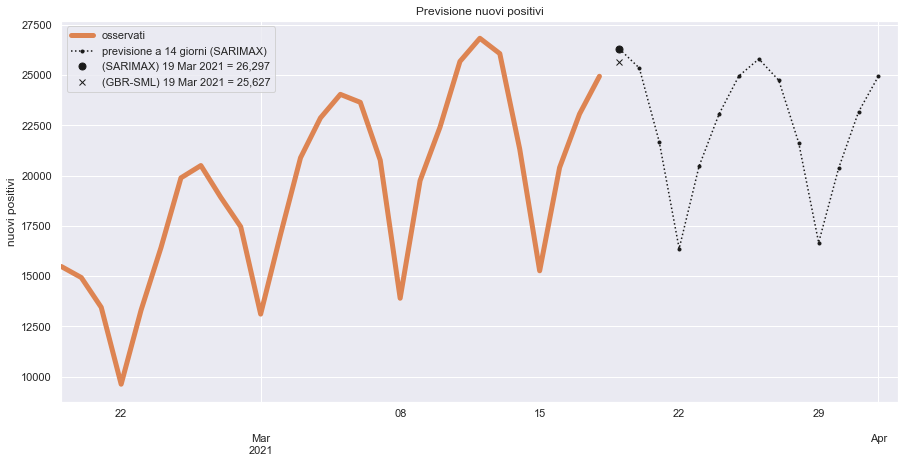

In [16]:
ax = df.iloc[-28:].nuovi_positivi.plot(lw=5, label='osservati', figsize=(15, 7), zorder=100, color='C1')
predict_future[1:].plot(ax=ax, color='k', ls=':', marker='.', label='previsione a 14 giorni (SARIMAX)')
ax.plot(
    forecast, marker='o', ms=7, ls='none', color='k', 
    label=f"(SARIMAX) {X_future.date().strftime('%d %b %Y')} = {forecast.values[0]:,.0f}")
ax.plot(
    X_future, Y_future, marker='x', color='k', ls='none',
    label=f"(GBR-SML) {X_future.date().strftime('%d %b %Y')} = {Y_future:,.0f}",
)

ax.set_xlim(ax.get_xlim()[0], predict_future.index[-1]+pd.Timedelta(days=1))
ax.set(
    title=f'Previsione nuovi positivi',
    ylabel='nuovi positivi'
)
ax.legend()
plt.show()

# Diagnostica

## SARIMAX

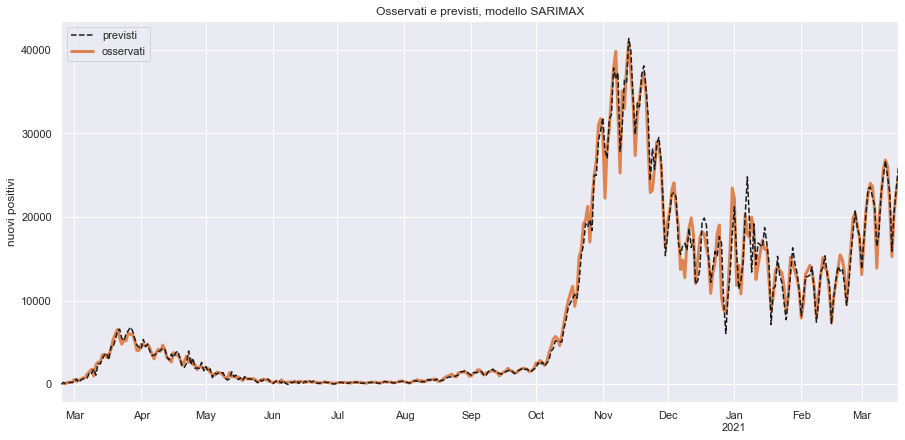

In [17]:
ax = predict_past.plot(
    figsize=(15, 7), title='Osservati e previsti, modello SARIMAX',
    ls='--', zorder=100,
    color='k', label='previsti',
    ylabel='nuovi positivi'
)
df.nuovi_positivi.plot(ax=ax, lw=3, label='osservati', color='C1')
ax.legend(loc='upper left')
plt.show()

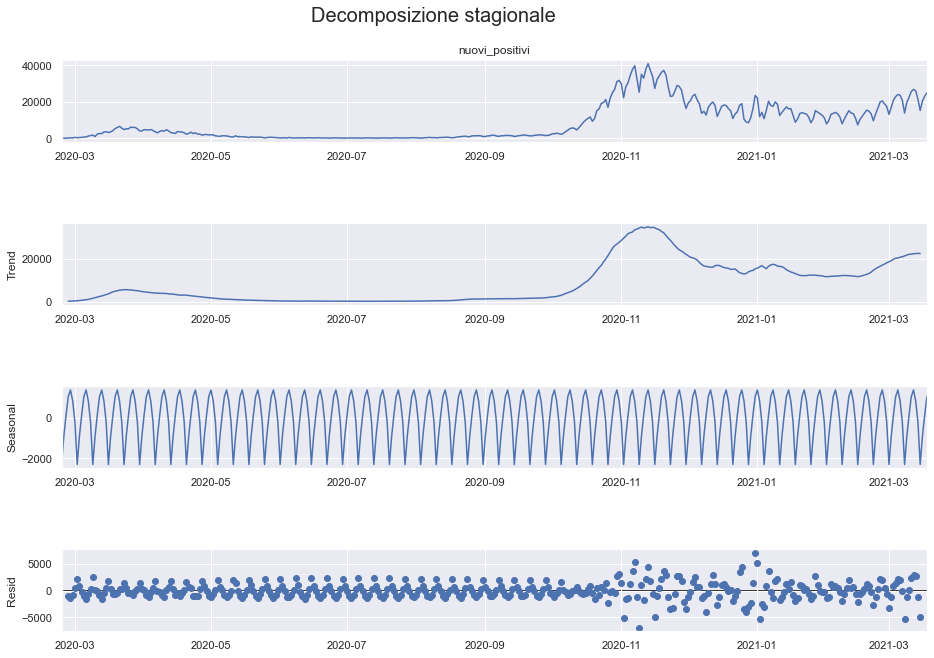

In [18]:
res = sm.tsa.seasonal_decompose(df.nuovi_positivi.dropna())
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Decomposizione stagionale', fontsize=20)
plt.show()

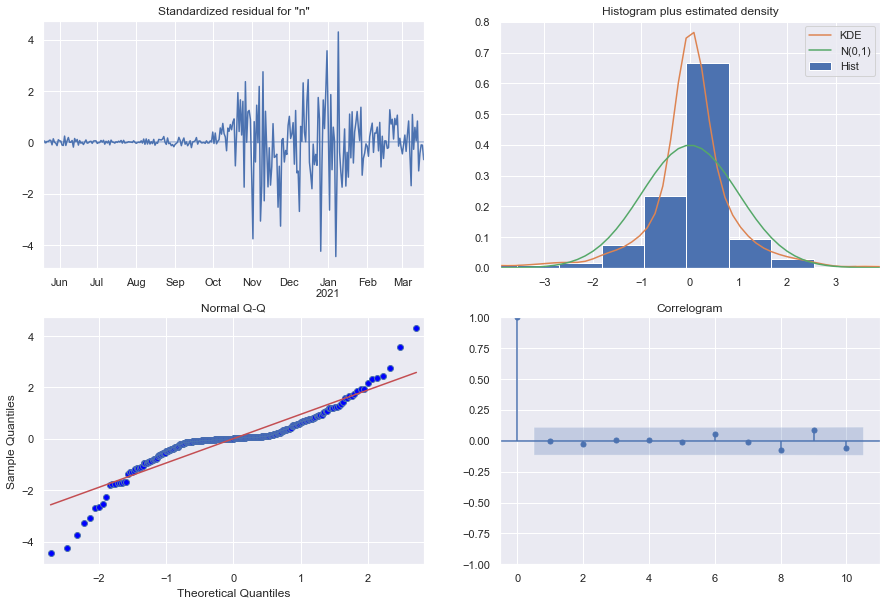

In [19]:
# Plot diagnostics
sarimax_fit.plot_diagnostics(figsize=(15,10));

In [20]:
# Print output summary
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                    SARIMAX Results                                                    
=======================================================================================================================
Dep. Variable:                                                  nuovi_positivi   No. Observations:                  389
Model:             SARIMAX(0, 1, 6)x(0, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 7)   Log Likelihood               -2645.559
Date:                                                         Fri, 19 Mar 2021   AIC                           5325.117
Time:                                                                 14:15:03   BIC                           5388.307
Sample:                                                             02-24-2020   HQIC                          5350.395
                                                                  - 03-18-2021                                         
Covariance Type:                                                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2121      0.052     -4.077      0.000      -0.314      -0.110
ma.L2         -0.2271      0.045     -5.060      0.000      -0.315      -0.139
ma.L3          0.0455      0.047      0.969      0.333      -0.047       0.138
ma.L4         -0.1220      0.054     -2.264      0.024      -0.228      -0.016
ma.L5          0.1173      0.047      2.487      0.013       0.025       0.210
ma.L6          0.2065      0.050      4.156      0.000       0.109       0.304
ma.S.L7       -0.4209      0.041    -10.244      0.000      -0.501      -0.340
ma.S.L14      -0.2134      0.056     -3.805      0.000      -0.323      -0.103
ma.S.L21      -0.0933      0.062     -1.499      0.134      -0.215       0.029
ma.S.L28       0.0381      0.067      0.570      0.568      -0.093       0.169
ma.S.L35      -0.0742      0.078     -0.947      0.344      -0.228       0.079
ma.S.L42      -0.0626      0.083     -0.755      0.450      -0.225       0.100
ma.S.L49      -0.0428      0.063     -0.681      0.496      -0.166       0.080
ma.S.L56       0.0711      0.089      0.801      0.423      -0.103       0.245
ma.S.L63       0.0024      0.098      0.024      0.981      -0.190       0.194
ma.S.L70       0.0359      0.092      0.392      0.695      -0.144       0.215
sigma2      2.332e+06   1.31e+05     17.807      0.000    2.08e+06    2.59e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               455.45
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):             250.64   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

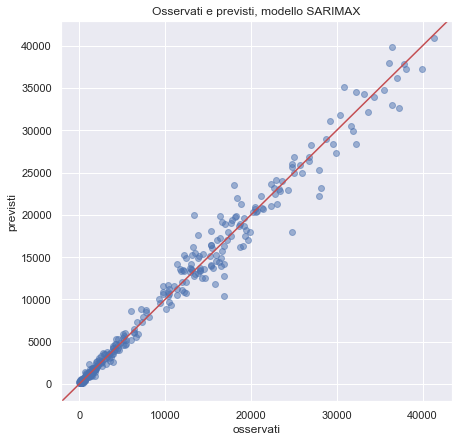

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    predict_past.values, df.nuovi_positivi.values,
    marker='o', ls='none', alpha=.5
)
ax.axline(xy1=(0, 0), slope=1, color='r')
ax.set(
    xlabel='osservati',
    ylabel='previsti',
    title='Osservati e previsti, modello SARIMAX'
)
plt.show()

## Gradient Boosting

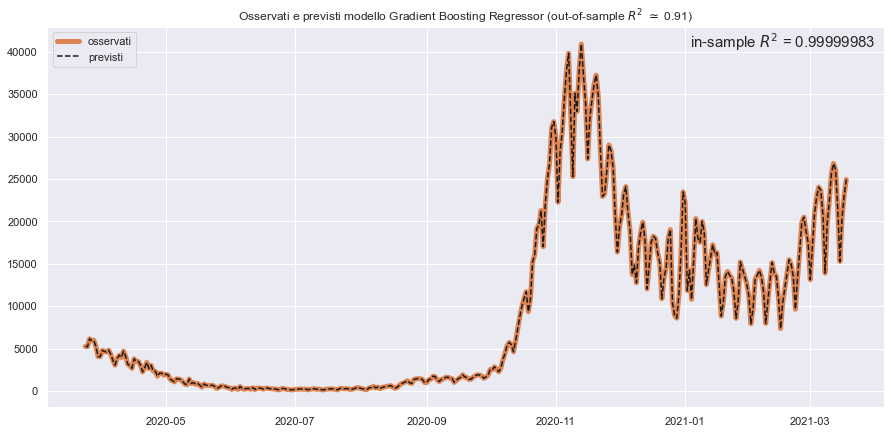

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(Y_obs, lw=5, label='osservati', color='C1')
ax.plot(Y_pre, label='previsti', color='k', ls='--')
ax.legend(loc='upper left')
ax.text(
    .99, .99, 
    f"in-sample $R^2$ = {score:.8f}",
    transform=ax.transAxes, fontsize=15,
    ha='right', va='top',
)
ax.set(
    title='Osservati e previsti modello Gradient Boosting Regressor '
    '(out-of-sample $R^2$ $\simeq$ 0.91)'
)
plt.show()

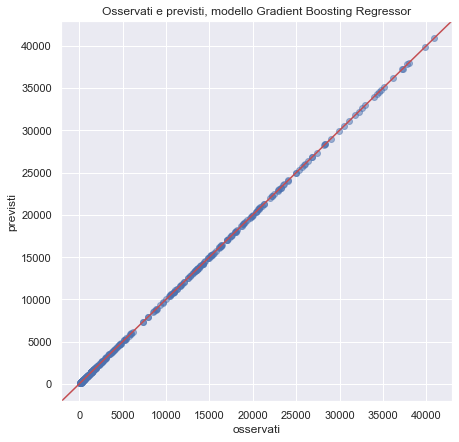

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    Y_obs, Y_pre,
    marker='o', ls='none', alpha=.5
)
ax.axline(xy1=(0, 0), slope=1, color='r')
ax.set(
    xlabel='osservati',
    ylabel='previsti',
    title='Osservati e previsti, modello Gradient Boosting Regressor'
)
plt.show()